In [34]:
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm


output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

### 1. Data preprocessing
+ 1.1 observation and cleaning
+ 1.2 splitting
+ 1.3 numpy or dataloader

+ download: [Kaggle link](https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip)
+ more:
    + Image augmentation
    + Pretrain model
    + Cross entropy loss
    + Confusion matrix

In [2]:
# check the number of each class
df_train = pd.read_csv("dataset/mnist_train.csv")
df_valid = pd.read_csv("dataset/mnist_test.csv")

print(df_train.shape, df_valid.shape)
df_train.head()

(60000, 785) (10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


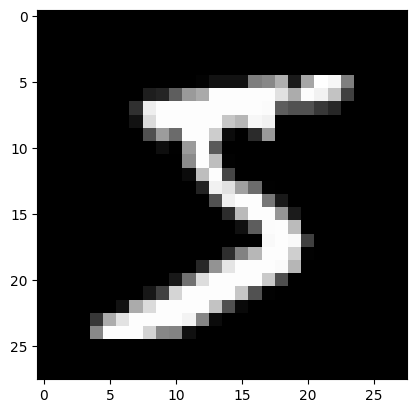

In [3]:
# visualization
img = df_train.iloc[0, 1:].to_numpy().reshape(28, 28)
plt.imshow(img, cmap="gray")
plt.show()

In [4]:
df_train["label"].value_counts(), df_valid["label"].value_counts()

(label
 1    6742
 7    6265
 3    6131
 2    5958
 9    5949
 0    5923
 6    5918
 8    5851
 4    5842
 5    5421
 Name: count, dtype: int64,
 label
 1    1135
 2    1032
 7    1028
 3    1010
 9    1009
 4     982
 0     980
 8     974
 6     958
 5     892
 Name: count, dtype: int64)

In [5]:
# sample subset
seed = 0
random.seed(seed)
sample_each_set = 1000

df_train_sample = df_train.sample(sample_each_set, random_state=seed)
df_valid_sample = df_valid.sample(sample_each_set, random_state=seed)
df_train_sample.shape, df_valid.shape, df_train_sample["label"].value_counts(), df_valid_sample["label"].value_counts()

((1000, 785),
 (10000, 785),
 label
 1    116
 6    111
 7    111
 0    110
 3    105
 2     96
 4     96
 8     86
 9     86
 5     83
 Name: count, dtype: int64,
 label
 4    122
 1    118
 3    104
 9    102
 7     98
 0     96
 8     92
 6     91
 2     90
 5     87
 Name: count, dtype: int64)

In [6]:
class MnistCsvClassificationDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.num_classes = 10
        self.labels = df["label"].to_numpy()
        self.imgs = df.iloc[:, 1:].to_numpy().reshape(-1, 28, 28)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 1-v, 1+v
            ]
        )

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index: int):
        """
        Args:
            index (int)
        Returns:
            x (torch.Tensor float): image, shape = (1, h, w)
            y (torch.Tensor int): class index, shape = (1,)
        """
        x = self.imgs[index]
        x = self.transform(x)  # (h, w, c) -> (c, h, w)
        x = x.type(torch.float32)
        y = torch.Tensor([self.labels[index]]).type(torch.int64)
        return x, y


trainset = MnistCsvClassificationDataset(df_train_sample)
validset = MnistCsvClassificationDataset(df_valid_sample)
trainset[0][0].shape, trainset[0][1]

(torch.Size([1, 28, 28]), tensor([3]))

In [7]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=False, shuffle=False)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=False, shuffle=False)

### 2. Model prepatation
+ 2.1 model
+ 2.2 loss
+ 2.3 more hyperparameters

In [38]:
# model
#model_name = "simple_cnn"
model_name = "resnet18"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(
            self,
            input_c: int,
            input_h: int,
            input_w: int,
            num_output_features: int,
            hidden_cnn: int = 64,
        ):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=input_c, out_channels=hidden_cnn, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=hidden_cnn, out_channels=hidden_cnn, kernel_size=3, stride=1, padding=1)
        self.dense1 = torch.nn.Linear(input_h * input_w * hidden_cnn // 4 ** 2, num_output_features)

        self.relu   = torch.nn.ReLU()
        self.maxpool= torch.nn.MaxPool2d(2)
        self.flatten = torch.nn.Flatten()
        # don't do softmax, since nn.functional.CrossEntropyLoss will do

    def forward(self, x):  # (B, 1, 28, 28)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 16, 14, 14)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 16, 7, 7)
        x = self.flatten(x)  # (B, 784)
        x = self.dense1(x)  # (B, 2)
        return x


if model_name == "simple_cnn":
    model = SimpleCNN(1, 28, 28, 10, 16).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    example_x, example_y = next(iter(trainset))
    print(model(example_x.unsqueeze(0)).shape)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Linear(in_features=784, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
num_parameters: 10330
torch.Size([1, 10])


In [39]:
class ResNet18(torch.nn.Module):
    def __init__(self, num_output_features: int):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True).to(device)
        in_features = self.resnet18.fc.in_features
        self.backbone.fc = torch.nn.Linear(in_features, num_output_features)

    def forward(self, x):  # (B, 3, h, w)
        return self.resnet18(x)  # (B, 2)

if model_name == "resnet18":
    model = SimpleCNN(1, 28, 28, 10, 16).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    example_x, example_y = next(iter(trainset))
    print(model(example_x.unsqueeze(0)).shape)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Linear(in_features=784, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
num_parameters: 10330
torch.Size([1, 10])


In [ ]:
class ViT(torch.nn.Module):
    def __init__(self, num_output_features: int):
        super().__init__()
        self.vit = models.vit_b_16(pretrained=True)
        self.dense = torch.nn.Linear(1000, num_output_features)
        
    def forward(self, x):  # (B, 3, h, w)
        x = self.vit(x)  # (B, 10)
        x = self.dense(x)
        return x

if model_name == "resnet18":
    model = ViT(10).to(device)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    example_x = torch.rand(3, 224, 224).unsqueeze(0).to(device)
    print(model(example_x).shape)

num_parameters: 86577666
torch.Size([1, 10])


In [55]:
#transforms.Resize((224, 224))(example_x).shape
example_x.shape

torch.Size([1, 28, 28])

In [11]:
# loss
loss_func = torch.nn.CrossEntropyLoss()

# more hyperparama
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
save_ckpts_per_epochs = 30

### 3. Training
+ 3.1 epoch: train loop, valid loop, save ckpts and loss
+ 3.2 check convergence

In [12]:
history = {"train_loss_list": [], "valid_loss_list": []}
pbar = tqdm(range(epochs))
for epoch in pbar:
    # training loop
    train_loss= 0.
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()      # 1. zero the parameter gradients
        pred = model(x)            # 2. f(x) and f'(x)
        loss = loss_func(pred, y.reshape(-1))  # 3. compute loss
        loss.backward()            # 4. send loss to torch
        optimizer.step()           # 5. update model parameters by torch loss 
        train_loss += loss.item() / len(trainset)
        
    # validation
    valid_loss = 0.
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_func(pred, y.reshape(-1))
            valid_loss += loss.item() / len(validset)

    # save
    history["train_loss_list"].append(train_loss)
    history["valid_loss_list"].append(valid_loss)
    with open(os.path.join(output_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)
    if valid_loss == min(history["valid_loss_list"]):
        torch.save(model.state_dict(), os.path.join(output_dir, "best.pt"))
    elif (epoch + 1) % save_ckpts_per_epochs == 0:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"epoch_{str(epoch).zfill(3)}.pt")
        )
    pbar.set_description(f"train_loss: {train_loss:.4f}, val_loss: {valid_loss:.4f}")

train_loss: 0.0002, val_loss: 0.0369: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


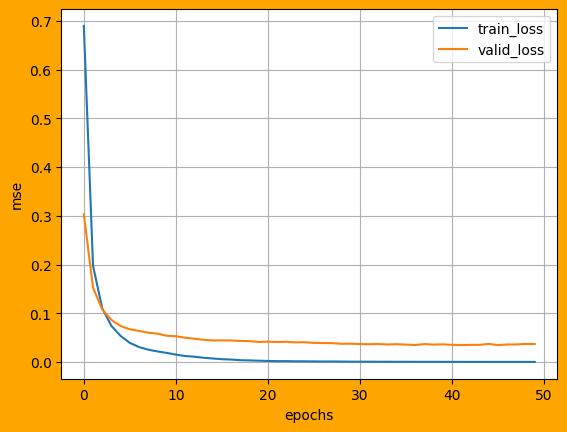

In [13]:
# check convergence
history = json.load(open(os.path.join(output_dir, "history.json")))
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['train_loss_list'], label='train_loss')
plt.plot(history['valid_loss_list'], label='valid_loss')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

### 4. Prediction
+ 4.1 testset
+ 4.2 (optional) metrics
+ 4.3 (optional) data improvement

In [29]:
# load checkpoints and inference

ckpt_path = os.path.join(output_dir, "best.pt")
trainloader = trainloader
validloader = validloader

model = SimpleCNN(1, 28, 28, 10, 16).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()
loss_func = torch.nn.CrossEntropyLoss(reduction="none")

for dataset_result, loader, name in [
        (df_train_sample, trainloader, "train"),
        (df_valid_sample, validloader, "valid")
    ]:
    prediction_list = []
    loss_list = []
    for x, y in loader:
        with torch.no_grad():
            pred = model(x)
            loss = loss_func(pred, y.reshape(-1))
            prediction_list.append(torch.nn.functional.softmax(pred).cpu().numpy())  # (B, 10)
            loss_list.append(loss.cpu().numpy())  # (B, 10) -> (B,)
    preds = np.concatenate(prediction_list)  # (N, num_output_features)
    loss = np.concatenate(loss_list)
    dataset_result[[f"pred_{i}" for i in range(10)]] = preds
    dataset_result["loss"] = loss
    dataset_result.to_csv(os.path.join(output_dir, f"{name}_dataset_result.csv"))
    print(dataset_result)

/var/folders/8c/4wnm02yj2qq_z31kr6t6sm4r0000gn/T/ipykernel_2082/3435913382.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction_list.append(torch.nn.functional.softmax(pred).cpu().numpy())  # (B, 10)


       label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...        pred_1  \
3048       3    0    0    0    0    0    0    0    0    0  ...  3.438342e-04   
19563      6    0    0    0    0    0    0    0    0    0  ...  1.696553e-14   
58303      6    0    0    0    0    0    0    0    0    0  ...  3.199358e-05   
8870       6    0    0    0    0    0    0    0    0    0  ...  3.744557e-14   
40228      0    0    0    0    0    0    0    0    0    0  ...  1.311638e-19   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...           ...   
13048      7    0    0    0    0    0    0    0    0    0  ...  1.341766e-16   
36895      6    0    0    0    0    0    0    0    0    0  ...  3.692836e-11   
36438      9    0    0    0    0    0    0    0    0    0  ...  1.204782e-15   
25996      3    0    0    0    0    0    0    0    0    0  ...  5.880150e-18   
35790      7    0    0    0    0    0    0    0    0    0  ...  4.822092e-08   

             pred_2        pred_3      

/var/folders/8c/4wnm02yj2qq_z31kr6t6sm4r0000gn/T/ipykernel_2082/3435913382.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction_list.append(torch.nn.functional.softmax(pred).cpu().numpy())  # (B, 10)


      label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...        pred_1  \
9394      8    0    0    0    0    0    0    0    0    0  ...  6.139543e-08   
898       7    0    0    0    0    0    0    0    0    0  ...  1.832699e-06   
2398      1    0    0    0    0    0    0    0    0    0  ...  9.998997e-01   
5906      7    0    0    0    0    0    0    0    0    0  ...  2.728123e-13   
2343      1    0    0    0    0    0    0    0    0    0  ...  9.637975e-01   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...           ...   
9319      9    0    0    0    0    0    0    0    0    0  ...  2.534837e-09   
2662      2    0    0    0    0    0    0    0    0    0  ...  1.583900e-12   
6925      0    0    0    0    0    0    0    0    0    0  ...  3.070391e-19   
8070      3    0    0    0    0    0    0    0    0    0  ...  1.719375e-13   
3651      1    0    0    0    0    0    0    0    0    0  ...  9.992441e-01   

            pred_2        pred_3        pred_4     

In [32]:
# (optional) metrics

df_valid_result = pd.read_csv(os.path.join(output_dir, "valid_dataset_result.csv"))
df_valid_result["pred_label"] = df_valid_result[[f"pred_{i}" for i in range(10)]].to_numpy().argmax(axis=1)
df_valid_result = df_valid_result[["label", "pred_label"]]
df_valid_result

,label,pred_label
0,8,5
1,7,7
2,1,1
3,7,7
4,1,1
...,...,...
995,9,9
996,2,2
997,0,0
998,3,3


In [35]:
print(accuracy_score(df_valid_result["label"], df_valid_result["pred_label"]))
print(confusion_matrix(df_valid_result["label"], df_valid_result["pred_label"]))

0.884
[[ 89   0   2   1   1   1   2   0   0   0]
 [  0 116   0   1   0   0   0   0   1   0]
 [  0   0  81   2   2   0   0   0   5   0]
 [  0   0   4  93   0   3   0   2   2   0]
 [  1   0   1   0 111   0   3   1   1   4]
 [  2   0   0   8   0  72   2   1   2   0]
 [  3   1   3   0   0   2  81   0   1   0]
 [  0   1   5   1   0   0   0  88   1   2]
 [  1   1   1   1   3   4   3   2  72   4]
 [  3   3   0   1   8   1   0   5   0  81]]


In [37]:
# (optional) data improvement

df_train_result = pd.read_csv(os.path.join(output_dir, "train_dataset_result.csv"))
df_train_result["pred_label"] = df_train_result[[f"pred_{i}" for i in range(10)]].to_numpy().argmax(axis=1)
df_train_improve = df_train_result[df_train_result["label"] != df_train_result["pred_label"]]
print(df_train_improve)

df_valid_result = pd.read_csv(os.path.join(output_dir, "valid_dataset_result.csv"))
df_valid_result["pred_label"] = df_valid_result[[f"pred_{i}" for i in range(10)]].to_numpy().argmax(axis=1)
df_valid_improve = df_train_result[df_valid_result["label"] != df_valid_result["pred_label"]]
print(df_valid_improve)

Empty DataFrame
Columns: [Unnamed: 0, label, 1x1, 1x2, 1x3, 1x4, 1x5, 1x6, 1x7, 1x8, 1x9, 1x10, 1x11, 1x12, 1x13, 1x14, 1x15, 1x16, 1x17, 1x18, 1x19, 1x20, 1x21, 1x22, 1x23, 1x24, 1x25, 1x26, 1x27, 1x28, 2x1, 2x2, 2x3, 2x4, 2x5, 2x6, 2x7, 2x8, 2x9, 2x10, 2x11, 2x12, 2x13, 2x14, 2x15, 2x16, 2x17, 2x18, 2x19, 2x20, 2x21, 2x22, 2x23, 2x24, 2x25, 2x26, 2x27, 2x28, 3x1, 3x2, 3x3, 3x4, 3x5, 3x6, 3x7, 3x8, 3x9, 3x10, 3x11, 3x12, 3x13, 3x14, 3x15, 3x16, 3x17, 3x18, 3x19, 3x20, 3x21, 3x22, 3x23, 3x24, 3x25, 3x26, 3x27, 3x28, 4x1, 4x2, 4x3, 4x4, 4x5, 4x6, 4x7, 4x8, 4x9, 4x10, 4x11, 4x12, 4x13, 4x14, ...]
Index: []

[0 rows x 798 columns]
     Unnamed: 0  label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  ...  \
0          3048      3    0    0    0    0    0    0    0    0  ...   
11        56085      8    0    0    0    0    0    0    0    0  ...   
12         5007      0    0    0    0    0    0    0    0    0  ...   
20        12231      6    0    0    0    0    0    0    0    0  ...   
23       